In [54]:
import pandas as pd
import numpy as np
import talib
import ta
from binance.client import Client
import matplotlib.pyplot as plt

In [55]:
client = Client()
SPOT_TRADE_FEES = 0.00075

In [56]:
def get_data(coin, look_back):
    data = pd.DataFrame(client.get_historical_klines(coin,
                                                    Client.KLINE_INTERVAL_5MINUTE,
                                                    str(look_back) + ' days ago UTC',
                                                    '5 min ago UTC'))
    data = data.iloc[:,:5]
    data.columns = ['Time', 'Open', 'High', 'Low', 'Close']
    data = data.set_index('Time')
    data.index = pd.to_datetime(data.index, unit='ms')
    data = data.astype(float)
    return data

In [57]:
stream = get_data('CVXBUSD', 1)

In [66]:
def signals(stream, enter=False):
    stream['rsi'] = talib.RSI(stream.Close)
    stream['fastk'], stream['fastd'] = talib.STOCHF(stream.High, stream.Low, stream.Close, fastk_period=14, fastd_period=3, fastd_matype=0)
    _, _, stream['hist'] = talib.MACD(stream.Close)
    stream.dropna(inplace=True)
    return stream

In [67]:
signals = signals(stream)
signals

,Open,High,Low,Close,rsi,fastk,fastd,hist,positions,v_Position
Time,,,,,,,,,,
2022-02-09 02:50:00,28.67,28.67,28.64,28.64,49.117552,19.924812,21.428571,-0.102905,0,0.00
2022-02-09 02:55:00,28.68,28.78,28.68,28.78,51.367885,25.187970,22.431078,-0.089885,0,0.00
2022-02-09 03:00:00,28.70,28.70,28.70,28.70,50.006894,28.640777,24.584520,-0.083926,0,0.00
2022-02-09 03:05:00,28.70,28.70,28.70,28.70,50.006894,7.042254,20.290333,-0.077408,0,0.00
2022-02-09 03:10:00,28.70,28.70,28.60,28.60,48.157182,0.000000,11.894343,-0.077086,0,0.00
...,...,...,...,...,...,...,...,...,...,...
2022-02-09 20:50:00,30.70,31.21,30.24,30.24,64.724573,48.128342,80.419371,0.104143,0,0.00
2022-02-09 20:55:00,30.22,30.22,29.96,30.02,58.083359,36.363636,61.497326,0.071791,1,30.02
2022-02-09 21:00:00,30.07,30.55,29.96,30.07,59.110251,39.037433,41.176471,0.049289,0,0.00


In [68]:
def long_position(signals, in_position=False):
    positions = []
    current_close = 0
    previous_close = 0
    for index, row in signals.iterrows():
        if (20 <= row['fastk'] <= 80) & (20 <= row['fastd'] <= 80) & (row['rsi'] > 50) & (row['hist'] > 0) and not in_position:
            positions.append(1)
            current_close = row['Close']
            in_position=True
        elif in_position and row['Close'] > (current_close*1.015) and current_close < previous_close:
            positions.append(-1)
            in_position=False
        else:
            positions.append(0)
        previous_close = row['Close']
    signals['positions'] = positions
    signals['v_Position'] = signals['positions'].abs() * signals['Close']
    signals = signals[signals['positions'] != 0]
    return signals

In [69]:
a = long_position(signals)
b_sides = a.loc[lambda x: x.positions > 0]
s_sides = a.loc[lambda x: x.positions < 0]

In [70]:
def plot_positions(closes, buys, sells):
    plt.figure(figsize=(12,6))
    plt.scatter(buys.index, buys.Close, marker="^", color='green')
    plt.scatter(sells.index, sells.Close, marker="v", color='red')
    plt.plot(closes.Close, label='COIN Closes', color='orange')
    plt.legend()
    plt.show()

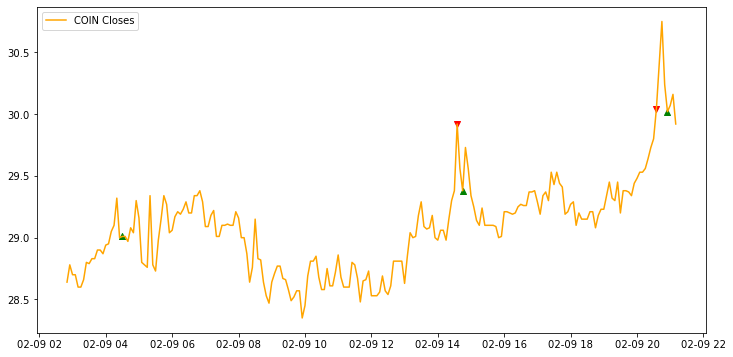

In [71]:
plot_positions(signals, b_sides, s_sides)

In [72]:
def back_test(dataframe):
    dataframe['ROC'] = dataframe.v_Position.pct_change()
    np_roc = np.asarray(dataframe['ROC'])
    roc_size = len(np_roc)
    perf = 0
    if (roc_size % 2) == 0:
        for i in range(0, (roc_size - 1), 2):
            perf = perf+np_roc[i+1]
    else:
        for i in range(0, (roc_size - 2), 2):
            perf = perf+np_roc[i+1]
    trade_fees = roc_size * SPOT_TRADE_FEES
    return roc_size, trade_fees, perf

In [73]:
trades, fees, performance = back_test(a)
net_profit = round((performance-fees)*100, 4)
print('Trades: {} | Fees: {}'.format(trades, fees))
print('Performance: {}% | Net profit: {}%'.format(round(performance*100, 4), net_profit))

Trades: 5 | Fees: 0.00375
Performance: 5.3833% | Net profit: 5.0083%


/opt/miniconda3/envs/pyta/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
